In [1]:
from __future__ import print_function
import sys
import numpy as np
import pandas as pd
pd.options.display.max_rows = 30
import matplotlib.pyplot as plt
%matplotlib notebook
import gvar as gv
import fkfpi_lib as flib
print("python version:", sys.version)
print("pandas version:", pd.__version__)
print("numpy  version:", np.__version__)
print("gvar   version:", gv.__version__)

python version: 3.6.1 |Anaconda 4.4.0 (x86_64)| (default, May 11 2017, 13:04:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
pandas version: 0.20.1
numpy  version: 1.12.1
gvar   version: 8.3.2


In [2]:
switches = dict()
switches['ensemble'] = [
    'a15m400','a12m400','a09m400',
    'a15m350','a12m350','a09m350',
    'a15m310','a12m310','a09m310',
    'a15m220','a12m220','a09m220','a12m220S','a12m220L',
    'a12m130']
switches['ansatz'] = dict()
switches['ansatz']['FV'] = True # True turns on NLO FV correction
switches['ansatz']['type'] = 'xpt' # Type of fit: 'xpt' or 'MA'
switches['ansatz']['a2dm'] = 'individual' # avg or individual
switches['scale'] = 'PK' # PP, PK, KK, LamChi = 4 * pi * sqrt(FA * FB)

In [3]:
# Set priors for Xpt
priors = dict()
priors['L5'] = gv.gvar(0.0, 1.0)
priors['s4'] = gv.gvar(0.0, 1.0)
priors['c4'] = gv.gvar(0.0, 1.0)
priors['d4'] = gv.gvar(0.0, 1.0)
priors['e4'] = gv.gvar(0.0, 1.0)
priors['s6'] = gv.gvar(0.0, 1.0)
priors['sc6'] = gv.gvar(0.0, 1.0)
priors['sd6'] = gv.gvar(0.0, 1.0)
priors['se6'] = gv.gvar(0.0, 1.0)
# Physical parameters from PDG
phys_p = dict()
# http://pdg.lbl.gov/2016/tables/rpp2016-tab-mesons-light.pdf
phys_p['mpi'] = gv.gvar(134.8, 0.3) #FLAG 2017 (16)
phys_p['mka'] = gv.gvar(494.2 , 0.3) #FLAG 2017 (16)
phys_p['F0'] = gv.gvar(80,20) #FLAG use of F0 in SU(2) correction for FK/Fpi
phys_p['meta'] = gv.gvar(547.862,0.017) #PDG
# http://pdg.lbl.gov/2015/reviews/rpp2015-rev-pseudoscalar-meson-decay-cons.pdf
phys_p['Fpi'] = gv.gvar(130.2/np.sqrt(2), 1.7/np.sqrt(2)) #PDG fpi+ eq(16)
phys_p['Fka'] = gv.gvar(155.6/np.sqrt(2), 0.4/np.sqrt(2)) #PDG fK++ eq(16)
if switches['scale'] == 'PK':
    phys_p['Lchi'] = 4*np.pi*np.sqrt(phys_p['Fpi']*phys_p['Fka'])
elif switches['scale'] == 'PP':
    phys_p['Lchi'] = 4*np.pi*phys_p['Fpi']
elif switches['scale'] == 'KK':
    phys_p['Lchi'] = 4*np.pi*phys_p['Fka']
phys_p['aw0'] = 0
# FLAG FK/Fpi
flag_FKFpi = gv.gvar(1.1933, 0.0029)

In [4]:
data = pd.read_csv('./github_fkfpi_v2.csv')
hisq_params = pd.read_csv('./hisq_params.csv')
mixed_params = pd.read_csv('./github_mixed_v1.csv')
data.groupby('ensemble').describe()

e0_kaon                                          \
                               count      mean       std       min       25%   
ensemble                                                                       
l1648f211b580m013m065m838     5001.0  0.404589  0.000242  0.403467  0.404436   
l1648f211b580m0166m065m838    5001.0  0.413700  0.000265  0.412774  0.413522   
l1648f211b580m0217m065m838    5001.0  0.427222  0.000265  0.426104  0.427046   
l2448f211b580m0064m0640m828   5001.0  0.386898  0.000207  0.385976  0.386768   
l2464f211b600m00507m0507m628  5001.0  0.310440  0.000213  0.309598  0.310295   
l2464f211b600m0102m0509m635   5001.0  0.324153  0.000208  0.323197  0.324018   
l2464f211b600m0130m0509m635   5001.0  0.333086  0.000160  0.332454  0.332975   
l2464f211b600m0170m0509m635   5001.0  0.343404  0.000142  0.342747  0.343311   
l3248f211b580m00235m0647m831  5001.0  0.377956  0.000243  0.376113  0.377803   
l3264f211b600m00507m0507m628  5001.0  0.310021  0.000170  0.308043  0.309915   
l3264f211b630m00945m037m440   5001.0  0.246968  0.000119  0.246560  0.246886   
l3264f211b630m0124m037m440    5001.0  0.255222  0.000124  0.254691  0.255142   
l3296f211b630m0074m037m440    5001.0  0.241099  0.000140  0.240585  0.241010   
l4064f211b600m00507m0507m628  5001.0  0.310158  0.000197  0.308693  0.310053   
l4864f211b600m00184m0507m628  5001.0  0.302014  0.000228  0.300484  0.301892   
l4896f211b630m00363m0363m430  5001.0  0.228699  0.000099  0.228029  0.228642   

                                                           e0_pion            \
                                   50%       75%       max   count      mean   
ensemble                                                                       
l1648f211b580m013m065m838     0.404602  0.404756  0.405563  5001.0  0.236078   
l1648f211b580m0166m065m838    0.413706  0.413878  0.414573  5001.0  0.264745   
l1648f211b580m0217m065m838    0.427225  0.427395  0.428207  5001.0  0.302819   
l2448f211b580m0064m0640m828   0.386910  0.387039  0.387517  5001.0  0.165306   
l2464f211b600m00507m0507m628  0.310442  0.310580  0.311167  5001.0  0.135512   
l2464f211b600m0102m0509m635   0.324156  0.324297  0.324802  5001.0  0.188675   
l2464f211b600m0130m0509m635   0.333085  0.333193  0.333687  5001.0  0.213968   
l2464f211b600m0170m0509m635   0.343407  0.343500  0.343885  5001.0  0.243450   
l3248f211b580m00235m0647m831  0.377958  0.378116  0.378828  5001.0  0.100832   
l3264f211b600m00507m0507m628  0.310025  0.310133  0.310743  5001.0  0.134246   
l3264f211b630m00945m037m440   0.246968  0.247049  0.247462  5001.0  0.157819   
l3264f211b630m0124m037m440    0.255225  0.255307  0.255719  5001.0  0.181139   
l3296f211b630m0074m037m440    0.241103  0.241195  0.241558  5001.0  0.140735   
l4064f211b600m00507m0507m628  0.310178  0.310290  0.310674  5001.0  0.134009   
l4864f211b600m00184m0507m628  0.302036  0.302165  0.302649  5001.0  0.081219   
l4896f211b630m00363m0363m430  0.228703  0.228763  0.229139  5001.0  0.097892   

                                ...     z0p_kaon           z0p_pion            \
                                ...          75%       max    count      mean   
ensemble                        ...                                             
l1648f211b580m013m065m838       ...     0.198529  0.199258   5001.0  0.257676   
l1648f211b580m0166m065m838      ...     0.198274  0.199151   5001.0  0.243052   
l1648f211b580m0217m065m838      ...     0.198638  0.199340   5001.0  0.230059   
l2448f211b580m0064m0640m828     ...     0.200906  0.201728   5001.0  0.317766   
l2464f211b600m00507m0507m628    ...     0.152135  0.152948   5001.0  0.228298   
l2464f211b600m0102m0509m635     ...     0.150452  0.151439   5001.0  0.187961   
l2464f211b600m0130m0509m635     ...     0.151239  0.151848   5001.0  0.179394   
l2464f211b600m0170m0509m635     ...     0.151983  0.152459   5001.0  0.172288   
l3248f211b580m00235m0647m831    ...     0.208497  0.210111   5001.0  0.469283   
l3264f211b600m0

In [5]:
fmt_data = flib.format_data(switches,data,mixed_params,hisq_params,priors)
#print(fmt_data)

In [6]:
fit = flib.fit_data(switches,fmt_data,phys_p)
print(fit.format(maxline=True))

Least Square Fit:
  chi2/dof [dof] = 0.62 [15]    Q = 0.86    logGBF = 56.687

Parameters:
             L5    0.00049 (32)      [     0.0 (1.0) ]  
             s4      -0.64 (23)      [     0.0 (1.0) ]  
             c4      -0.85 (75)      [     0.0 (1.0) ]  
             d4       0.18 (98)      [     0.0 (1.0) ]  
             e4       1.04 (71)      [     0.0 (1.0) ]  *
             s6       0.37 (15)      [     0.0 (1.0) ]  
            sc6      -0.15 (86)      [     0.0 (1.0) ]  
            sd6      -0.03 (97)      [     0.0 (1.0) ]  
            se6       0.13 (74)      [     0.0 (1.0) ]  
          mpi 0    0.30284 (31)      [  0.30283 (31) ]  
              1    0.24345 (16)      [  0.24346 (16) ]  
              2    0.18115 (15)      [  0.18114 (15) ]  
              3    0.26468 (29)      [  0.26475 (30) ]  
              4    0.21398 (20)      [  0.21397 (20) ]  
              5    0.15780 (20)      [  0.15783 (20) ]  
              6    0.23610 (29)      [  0.23609 (29) 

<IPython.core.display.Javascript object>


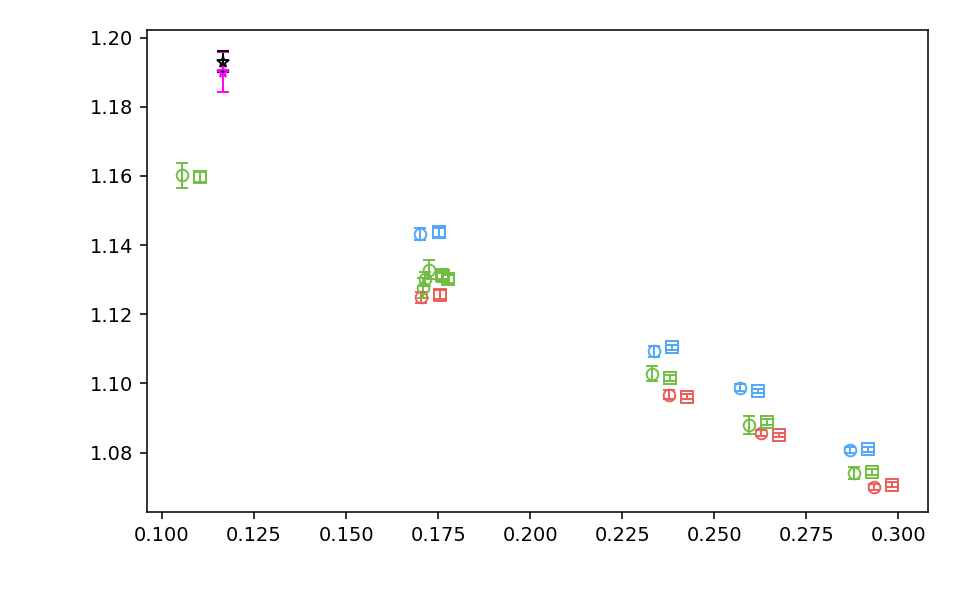

 a15m400 1.06993(91) 1.07072(67)
 a12m400 1.0741(16) 1.07429(87)
 a09m400 1.08071(94) 1.08094(68)
 a15m350 1.08569(90) 1.08496(55)
 a12m350 1.0880(27) 1.08888(85)
 a09m350 1.09879(97) 1.09780(60)
 a15m310 1.0968(14) 1.09620(65)
 a12m310 1.1028(22) 1.10146(85)
 a09m310 1.1093(16) 1.11040(66)
 a15m220 1.1249(16) 1.1256(13)
 a12m220 1.1303(21) 1.1310(11)
 a09m220 1.1433(17) 1.1438(13)
a12m220S 1.1329(27) 1.1302(11)
a12m220L 1.1276(28) 1.1312(11)
 a12m130 1.1602(35) 1.1596(14)
prediction from LQCD
FK / Fpi =  1.1926(59)
FK+/Fpi+ =  1.1901(58)


In [7]:
fig = plt.figure('FK/Fpi',figsize=(7,4.326237))
ax = plt.axes([0.15,0.15,0.8,0.8])
colors ={'a15m400':'#ec5d57','a15m350':'#ec5d57','a15m310':'#ec5d57','a15m220':'#ec5d57','a15m130':'#ec5d57',
        'a12m400':'#70bf41','a12m350':'#70bf41','a12m310':'#70bf41','a12m220':'#70bf41','a12m130':'#70bf41','a12m220S':'#70bf41','a12m220L':'#70bf41',
        'a09m400':'#51a7f9','a09m350':'#51a7f9','a09m310':'#51a7f9','a09m220':'#51a7f9'}
for i,e in enumerate(switches['ensemble']):
    epi = fmt_data['p']['mpi'][i]/fmt_data['x']['Lchi'][i]
    print('%8s %s %s' %(e,str(fmt_data['y'][i]),str(fit.fcn(fit.x,fit.p)[i])))
    ax.errorbar(epi.mean,fmt_data['y'][i].mean,yerr=fmt_data['y'][i].sdev,color=colors[e],marker='o',elinewidth=1,capsize=3,mfc='none')
    ax.errorbar(epi.mean+.005,fit.fcn(fit.x,fit.p)[i].mean,yerr=fit.fcn(fit.x,fit.p)[i].sdev,color=colors[e],marker='s',elinewidth=1,capsize=3,mfc='none')
fkp = flib.fkfpi_phys(phys_p,fit)
ax.errorbar((phys_p['mpi']/(4.*np.pi*phys_p['Fpi'])).mean,fkp.mean,yerr=fkp.sdev,color='magenta',marker='*',elinewidth=1,capsize=3,mfc='none')
ax.errorbar((phys_p['mpi']/(4.*np.pi*phys_p['Fpi'])).mean,1.193,yerr=0.003,color='black',marker='*',elinewidth=1,capsize=3,mfc='none')
plt.savefig('FKFpi_vs_epi.pdf',transparent=True)